Measure the Spin Qubit using RF via SHFQC device

Based upon `shfqa_qd_new_CS_20240429.ipynb` and https://github.com/zhinst/laboneq/blob/main/examples/03_superconducting_qubits/00_qubit_tuneup_shfsg_shfqa_shfqc.ipynb


In [1]:
%matplotlib inline
import local_broom

Added 'quench/' and 'quench/libraries' for easy importing.


In [2]:
# LabOne Q:
#from laboneq.simple import *

from laboneq.dsl.experiment import (
    #Section,
    Experiment,
    ExperimentSignal,
    #Sweep,
    pulse_library
)
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.session import Session
from laboneq.dsl.calibration import (
    Calibration,
    SignalCalibration,
    Oscillator
)

from laboneq.dsl.enums import (
    AcquisitionType,
    AveragingMode,
    SectionAlignment,
    PortMode,
    ModulationType
)

from laboneq.dsl import LinearSweepParameter  # SweepParameter

from laboneq.pulse_sheet_viewer.pulse_sheet_viewer import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# plotting and fitting functionality
#from laboneq.analysis.fitting import (
    #lorentzian,
    #oscillatory,
    #oscillatory_decay,
#)

#from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# for saving results and pulse sheets
from pathlib import Path
import time

import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm

from monty import Monty

C:\Users\LD2007\AppData\Local\Temp\ipykernel_24380\3238781331.py:47: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Physical lines are the actual ports on the device. These are specified in the descriptor as our specific ports.

The logical lines can be any of the following. Multiple logical lines can correspond to the same physical line and their groups can be across different devices [reference](https://docs.zhinst.com/labone_q_user_manual/concepts/logical_signal_lines)
- **Drive** control lines to adjust qubits
- **Measure** line our RF measurement signal goes down
- **Acquire** response line from the measure line. Readout lines

Experiment signals are generic parameters defined for each experiment. Upon creation, they need to be mapped to logical signals. The reason for this distinction is so for superconducting qubits it is easy to change from q0 to q1 but in our case this is unnecessary


In [3]:
experiment = {
    "desc": "Test the RF code for sweeping the SET."
}

monty = Monty("rf.p1 ramps", experiment)

Started new experiment rf.p1_ramps


In [4]:
descriptor = """
instruments:
  SHFQC:
  - address: DEV12158
    uid: device_shfqc
    interface: 1gbe

connections:
  device_shfqc:
    - iq_signal: set/drive_line
      ports: SGCHANNELS/0/OUTPUT
    - iq_signal: p1/drive_line
      ports: SGCHANNELS/1/OUTPUT
    - iq_signal: p2/drive_line
      ports: SGCHANNELS/2/OUTPUT
    - iq_signal: j1/drive_line
      ports: SGCHANNELS/3/OUTPUT
    - iq_signal: bt/drive_line  # bias tee
      ports: SGCHANNELS/4/OUTPUT
    - iq_signal: set/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: set/acquire_line
      ports: [QACHANNELS/0/INPUT]
"""


In [5]:
def plot_sweeper(f, result, unwrap = True, deg = True, xlabel="Frequency (GHz)", ylabel="Power (dBm)", monty=None):
    """Plot results from Sweeper"""
    f = f/1e9
    power = 10*np.log10(np.abs(result)**2/50*1000)
    phase = np.unwrap(np.angle(result, deg = deg)) if unwrap is True else np.angle(result, deg = deg)
    phase_unit = 'deg' if deg else 'rad'
    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
    ax0.plot(f, power, '.-', color = 'steelblue', label = 'power')
    #ax0.legend(loc='upper left')
    ax0.set_ylabel(ylabel)
    ax1.plot(f, phase, '.-', color = 'orange', label = 'phase')
    #ax1.legend(loc='upper left')
    ax1.set_xlabel(xlabel)
    fig.align_ylabels([ax0, ax1])
    ax0.grid()
    ax1.grid()
    ax1.set_ylabel(f'Phase ({phase_unit})')
    plt.tight_layout()
    if monty is not None:
        ax0.set_title(monty.identifier + "." + monty.runname)
        monty.savefig(plt, "sweep")
    else:
        plt.show()

In [6]:
# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor,
    server_host="localhost",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

# Create shortcuts to logical signals (LSG) for convenience
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
    for qubit_name in device_setup.logical_signal_groups.keys()
}
# Use like lsg["set"]["drive_line"]

# perform experiments in emulation mode only? - if True, also generate dummy data for fitting
emulate = False

# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

[2024.07.30 14:45:56.251] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is C:\Users\LD2007\Documents\Si_CMOS_james\quench\june\laboneq_output\log
[2024.07.30 14:45:56.253] INFO    VERSION: laboneq 2.32.0
[2024.07.30 14:45:56.255] INFO    Connecting to data server at localhost:8004
[2024.07.30 14:45:56.363] INFO    Connected to Zurich Instruments LabOne Data Server version 24.04 at localhost:8004
[2024.07.30 14:45:59.039] WARNING SHFQC/QA:dev12158: Include the device options 'SHFQC/QC6CH' in the device setup ('options' field of the 'instruments' list in the device setup descriptor). This will become a strict requirement in the future.
[2024.07.30 14:45:59.775] INFO    Configuring the device setup
[2024.07.30 14:45:59.885] INFO    The device setup is configured


In [19]:
#session.disconnect()

[2024.07.30 14:54:33.693] INFO    Disconnecting from all devices and servers...
[2024.07.30 14:54:34.552] INFO    Successfully disconnected from all devices and servers.


In [7]:
# define device parameters

qubit_parameters = {
    #'ro_freq':  10e6,           # readout frequency of qubit 0 in [Hz] - relative to local oscillator for readout drive upconversion
    #'ro_amp': 0.5,              # readout amplitude
    #'ro_amp_spec': 0.05,         # readout amplitude for spectroscopy
    #'ro_len': 1.0e-6,           # readout pulse length in [s]
    #'ro_len_spec': 1.0e-6,      # readout pulse length for resonator spectroscopy in [s]
    #'ro_pulse_delay': 0e-9,     # readout delay after last drive signal in [s]
    #'ro_int_delay': 0e-9,     # readout line offset calibration - delay between readout pulse and start of signal acquisition in [s]
    #'ro_pout_range': -30,
    #"ro_pin_range": -5,

    # legacy from superconducting qubits
    #'qb_freq': 395.0e6,   # dr_df   # qubit 0 drive frequency in [Hz] - relative to local oscillator for qubit drive upconversion
    #'qb_amp_spec': 0.01,         # drive amplitude of qubit spectroscopy
    #'qb_len_spec': 15e-6,        # drive pulse length for qubit spectroscopy in [s]
    
    #'qb_len': 4e-7,             # qubit drive pulse length in [s]
    #'pi_amp': 0.5,              # qubit drive amplitude for pi pulse
    #'pi_half_amp': 0.25,        # qubit drive amplitude for pi/2 pulse
    #'qb_t1': 100e-6,            # qubit T1 time
    #'qb_t2': 100e-6,            # qubit T2 time
    #'relax': 200e-6,             # delay time after each measurement for qubit reset in [s]

    # up / downconversion settings - to convert between IF and RF frequencies

    #'qb_lo': 4.0e9,              # qubit LO frequency in [Hz]
    'ro_lo': 1.0e9,   # (ro_cent_f)   # readout LO frequency in [Hz]
    #'dr_lo': 7.0e9,   # (dr_cent_f)  # drive LO frequency [Hz]
}

## frequency sweep impendence network

In [8]:
def compile_run(session, exp_params, exp):
    compiler_settings = {
        "OUTPUT_EXTRAS": True,
        "MAX_EVENTS_TO_PUBLISH": 1000,
    }
    compiled_exp = session.compile(exp, compiler_settings=compiler_settings)
    results = session.run(compiled_exp)
    root = Path("/Users/LD2007/Documents/Si_CMOS_james/pulse_sheets")
    root.mkdir(parents=True, exist_ok=True)
    show_pulse_sheet(root.joinpath(f"{exp_params["exp_name"]}"), compiled_exp)
    #if exp_params["plot_simulation"] == 1:
    #plot_simulation(compiled_exp, start_time=exp_params["plt_start_time"], length=exp_params["plt_length"])
    return results

def topower(res, unwrap=True, deg=True):
    power = 10*np.log10(np.abs(res)**2/50*1000)
    phase = np.unwrap(np.angle(res, deg = deg)) if unwrap is True else np.angle(res, deg = deg)
    #phase_unit = 'deg' if deg else 'rad'
    return power, phase

In [9]:
def res_spectroscopy(session, exp_params):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp = Experiment(
        uid="spectroscopy",
        signals=[
            ExperimentSignal(("measure"), map_to=lsg["set"]["measure_line"]),
            ExperimentSignal(("acquire"), map_to=lsg["set"]["acquire_line"]),
        ],
    )
    # define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"] + "_shots",
        count=2**exp_params["num_averages"],
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        averaging_mode=AveragingMode.CYCLIC,  # SEQUENTIAL?
    ):
        with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["freq_sweep"]):
            # readout pulse and data acquisition
            with exp.section(uid="spectroscopy"):
                # resonator signal readout
                exp.acquire(
                    signal="acquire",
                    handle=exp_params["exp_name"],
                    length=exp_params["integration_time"],
                )
            # relax time after readout - for qubit relaxation to groundstate and signal processing
            with exp.section(uid="relax", length=exp_params["wait_after_int"]):
                exp.reserve(signal="measure")
                exp.reserve(signal="acquire")
                    
    cal = Calibration()
    # sets the oscillator of the experimental measure signal
    cal["measure"] = SignalCalibration(
        local_oscillator = Oscillator(frequency = exp_params["ro_lo"]),
        oscillator=Oscillator(frequency=exp_params["freq_sweep"], modulation_type=ModulationType.HARDWARE),
        amplitude=exp_params["ro_osc_gain"],
        range = exp_params["ro_pout_range"]
    )
    cal["acquire"] = SignalCalibration(
        local_oscillator = Oscillator("ro_cent_f_acquire", frequency = exp_params["ro_lo"]),
        range = exp_params["ro_pin_range"]
    )
    exp.set_calibration(cal)

    results = compile_run(session, exp_params, exp)

    return results

[2024.07.30 14:46:10.157] INFO    Starting LabOne Q Compiler run...
[2024.07.30 14:46:10.247] INFO    Schedule completed. [0.087 s]
[2024.07.30 14:46:10.484] INFO    Code generation completed for all AWGs. [0.236 s]
[2024.07.30 14:46:10.485] INFO    Completed compilation step 1 of 1. [0.324 s]
[2024.07.30 14:46:10.494] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.30 14:46:10.494] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 14:46:10.495] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.30 14:46:10.496] INFO      device_shfqc     0         21            0           0         0  
[2024.07.30 14:46:10.497] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.30 14:46:10.498] INFO      TOTAL                      21            0                     0  
[2024.07.30 14:46:10.499] INFO     ────────────────────────────────────────────────────

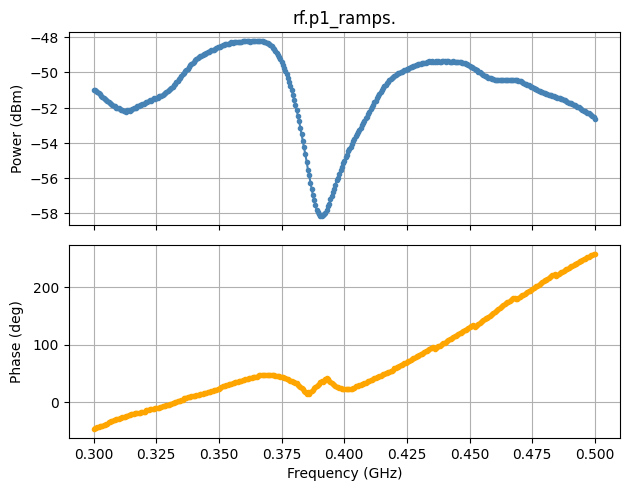

In [10]:
start_freq = 300.0e6
stop_freq = 500.0e6
num_points = 401

freq_sweep = LinearSweepParameter(
    uid ="res_freq_set",
    start = start_freq,
    stop = stop_freq,
    count = num_points,
    axis_name="Frequency [Hz]"
)

exp_params_spec = qubit_parameters.copy()
exp_params_spec.update({
    "exp_name": "cw",
    "wait_after_int": 7e-6,
    "integration_time": 2e-6,
    "ro_osc_gain": 0.5,
    #"plot_simulation": 0,
    "num_averages": 10,
    "freq_sweep": freq_sweep,
    

    # overwrite above
    "ro_lo": 1.0e9,
    "ro_pout_range": -15,
    "ro_pin_range": -5
})

# monty.newrun("spectroscopy", exp_params_spec)
results_cw_res = res_spectroscopy(session, exp_params_spec)

f = np.transpose(np.array(results_cw_res.acquired_results[exp_params_spec["exp_name"]].axis))
data = results_cw_res.acquired_results[exp_params_spec["exp_name"]].data
monty.save({"data": data})
plot_sweeper(f, data, monty=monty)

In [15]:
#monty.save({"data": data})
#plot_sweeper(f, data, monty=monty)

In [12]:
# rough approximation of the optimal frequency
f[np.argmin(np.abs(data))]

array([4.07e+08])

## SET gate (coulomb blocking) sweep

In [11]:
# create the experiment
def spectroscopy(session, exp_params):
    exp = Experiment(uid=exp_params["exp_name"],
                     signals = [
                         ExperimentSignal(("drive_set"), map_to=lsg["set"]["drive_line"]),
                         ExperimentSignal(("measure"), map_to=lsg["set"]["measure_line"]),
                         ExperimentSignal(("acquire"), map_to=lsg["set"]["acquire_line"]),
                     ]
                    )
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"] + "_shots",
        count=2**exp_params["num_averages"],
        acquisition_type = AcquisitionType.SPECTROSCOPY,
        averaging_mode = AveragingMode.SEQUENTIAL,
    ):
        with exp.sweep(uid='sweep amp set', parameter=exp_params["dr_amp_sweep"]):
            with exp.section(uid="set_sweep", alignment = SectionAlignment.RIGHT):
                with exp.section(uid = "g1_1"):
                    exp.play(signal = "drive_set",
                             pulse = exp_params["dr_pulse"],
                             amplitude = exp_params["dr_amp_sweep"],
                             phase = 180)  # note that the phase does not affect the output amplitude 

                with exp.section(uid="readout"):
                    exp.measure(
                        acquire_signal ="acquire",
                        handle = "results",
                        integration_length=exp_params["integration_time"],
                        reset_delay=exp_params["wait_after_int"],
                    )
                    

    cal = Calibration()
  
    cal["drive_set"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=0),  # exp_params["qb_freq"]),
        port_mode=PortMode.LF,
        range=exp_params["dr_pout_range"])
    
    cal["acquire"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),  # exp_params["ro_lo"]),
        port_mode=PortMode.LF,
        oscillator=Oscillator(frequency=exp_params["set_freq"]),
        # port_delay = 100e-6,
        range=exp_params["ro_pin_range"])

    cal["measure"] = SignalCalibration(
        #local_oscillator = Oscillator(frequency = exp_params["ro_lo"]),
        #oscillator=Oscillator(frequency=exp_params["qb_freq"]),
        port_mode=PortMode.LF,
        range = exp_params["ro_pout_range"]
    )

    exp.set_calibration(cal)

    results = compile_run(session, exp_params, exp)
    return results

Started new run rf_ST_sweep.5
[2024.07.30 14:52:53.368] INFO    Resolved modulation type of oscillator 'osc_25' on signal 'acquire' to HARDWARE
[2024.07.30 14:52:53.369] INFO    Resolved modulation type of oscillator 'osc_23' on signal 'drive_set' to HARDWARE
[2024.07.30 14:52:53.370] INFO    Starting LabOne Q Compiler run...
[2024.07.30 14:52:53.403] INFO    Schedule completed. [0.031 s]
[2024.07.30 14:52:56.292] INFO    Code generation completed for all AWGs. [2.888 s]
[2024.07.30 14:52:56.293] INFO    Completed compilation step 1 of 1. [2.921 s]
[2024.07.30 14:52:56.298] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 14:52:56.299] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.30 14:52:56.300] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.30 14:52:56.300] INFO      device_shfqc        0         12            0           0         0  
[2024.07.30 14:52:56.

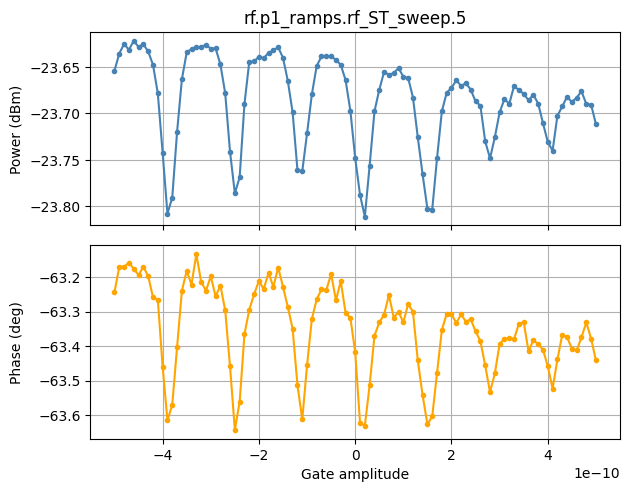

In [17]:
# define pulses

dr_pulse_len = 120e-6
dr_pulse = pulse_library.const(uid = "dr_pulse", amplitude = 1.0, length = dr_pulse_len, can_compress=True)
dr_amp_sweep = LinearSweepParameter("dr_amp", start=-0.5, stop = 0.5, count=101)

exp_set_sweep = qubit_parameters.copy()
exp_set_sweep.update({
    "exp_name": "sweep",
    "wait_after_int": 10e-6,
    "integration_time": 25e-6,
    "ro_osc_gain": 0.5,

    "set_freq": 406.6e6,
    "num_averages": 5,
    "dr_pout_range": 5,
    "ro_pout_range": -10,
    "ro_pin_range": -10,

    "dr_pulse": dr_pulse,  # drive pulse
    "dr_amp_sweep": dr_amp_sweep,  # linear DC sweep
})

monty.newrun("rf ST sweep", exp_set_sweep)
results = spectroscopy(session, exp_set_sweep)

data = results.acquired_results["results"].data
monty.save({"data": data})
plot_sweeper(dr_amp_sweep, data, xlabel="Gate amplitude", monty=monty)

## frequency sweep over SET range

In [107]:
# create the experiment
def freqset(session, exp_params):
    exp = Experiment(uid=exp_params["exp_name"],
                     signals = [
                         ExperimentSignal(("drive_set"), map_to=lsg["set"]["drive_line"]),
                         ExperimentSignal(("measure"), map_to=lsg["set"]["measure_line"]),
                         ExperimentSignal(("acquire"), map_to=lsg["set"]["acquire_line"]),
                     ]
                    )
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"] + "_shots",
        count=2**exp_params["num_averages"],
        acquisition_type = AcquisitionType.SPECTROSCOPY,
        averaging_mode = AveragingMode.SEQUENTIAL,
    ):
        with exp.sweep(uid="sweep freq", parameter=exp_params["freq_sweep"]):
            with exp.sweep(uid='sweep amp set', parameter=exp_params["dr_amp_sweep"]):
                with exp.section(uid="set_sweep", alignment = SectionAlignment.RIGHT):
                    with exp.section(uid = "g1_1"):
                        exp.play(signal = "drive_set",
                                 pulse = exp_params["dr_pulse"],
                                 amplitude = exp_params["dr_amp_sweep"],
                                 phase = 180)  # note that the phase does not affect the output amplitude 
    
                    with exp.section(uid="readout"):
                        exp.measure(
                            acquire_signal = "acquire",
                            handle = "results",
                            integration_length=exp_params["integration_time"],
                            reset_delay=exp_params["wait_after_int"]
                        )

                        # resonator signal readout
                        #exp.acquire(
                        #    signal="acquire",
                        #    handle="results",
                        #    length=exp_params["integration_time"],
                        #)
                    # relax time after readout - for qubit relaxation to groundstate and signal processing
                    #with exp.section(uid="relax", length=exp_params["wait_after_int"]):
                    #    exp.reserve(signal="measure")
                    #    exp.reserve(signal="acquire")
                        #exp.reserve(signal="drive_set")

    cal = Calibration()
  
    cal["drive_set"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=0),  # exp_params["qb_freq"]),
        port_mode=PortMode.LF,
        range=exp_params["dr_pout_range"])
    
    cal["acquire"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),  # exp_params["ro_lo"]),
        port_mode=PortMode.LF,
        #oscillator=Oscillator(frequency=exp_params["set_freq"]),
        # port_delay = 100e-6,
        range=exp_params["ro_pin_range"])

    # CW output for measurement
    cal["measure"] = SignalCalibration(
        #local_oscillator = Oscillator(frequency = exp_params["ro_lo"]),
        local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=exp_params["freq_sweep"], modulation_type=ModulationType.HARDWARE),
        port_mode=PortMode.LF,
        range = exp_params["ro_pout_range"]
    )

    exp.set_calibration(cal)

    results = compile_run(session, exp_params, exp)
    return results

Run finished and took 0:00:11.780312.
Started new run rf_ST_freq_sweep.23
[2024.06.22 23:10:01.166] INFO    Resolved modulation type of oscillator 'osc_335' on signal 'drive_set' to HARDWARE
[2024.06.22 23:10:01.167] INFO    Starting LabOne Q Compiler run...
[2024.06.22 23:10:02.172] INFO    Schedule completed. [1.003 s]
[2024.06.22 23:10:36.454] INFO    Code generation completed for all AWGs. [34.282 s]
[2024.06.22 23:10:36.457] INFO    Completed compilation step 1 of 1. [35.288 s]
[2024.06.22 23:10:36.463] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.22 23:10:36.468] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.22 23:10:36.469] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.22 23:10:36.472] INFO      device_shfqc        0         12            0           0         0  
[2024.06.22 23:10:36.474] INFO      device_shfqc_sg     0        620          202       

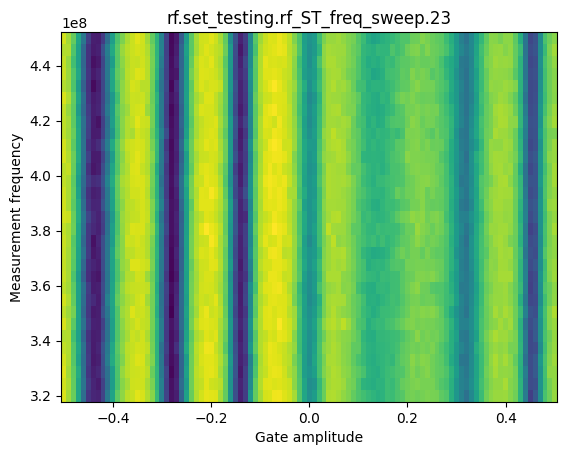

In [108]:
# similar setup to above, but vary the set_freq over a range

start_freq = 320.0e6
stop_freq = 450.0e6
num_points = 31

# frequencies to sweep over
freq_sweep = LinearSweepParameter(
    uid ="res_freq_set",
    start = start_freq,
    stop = stop_freq,
    count = num_points,
    axis_name="Frequency [Hz]"
)

# define the gate DC pulses
dr_pulse_len = 120e-6
dr_pulse = pulse_library.const(uid = "dr_pulse", amplitude = 1.0, length = dr_pulse_len, can_compress=True)
dr_amp_sweep = LinearSweepParameter("dr_amp", start=-0.5, stop = 0.5, count=101)

exp_set_freq_sweep = qubit_parameters.copy()
exp_set_freq_sweep.update({
    "exp_name": "sweep",
    "wait_after_int": 10e-6,
    "integration_time": 100e-6,
    "ro_osc_gain": 0.5,
    
    "num_averages": 8,
    "dr_pout_range": 5,
    "ro_pout_range": -20,
    "ro_pin_range": 0,

    "freq_sweep": freq_sweep,  # frequencies to sweep over
    "dr_pulse": dr_pulse,  # drive pulse
    "dr_amp_sweep": dr_amp_sweep,  # linear DC sweep
})

monty.newrun("rf ST freq sweep", exp_set_freq_sweep)
results = freqset(session, exp_set_freq_sweep)
data = results.acquired_results["results"].data
monty.save({"data": data})
#plot_sweeper(dr_amp_sweep, data, xlabel="Gate amplitude", monty=monty)

plt.pcolormesh(dr_amp_sweep.values, freq_sweep.values, np.abs(data), shading="nearest")
plt.xlabel("Gate amplitude")
plt.ylabel("Measurement frequency")
plt.title(monty.identifier + "." + monty.runname)
monty.savefig(plt, "2d")

In [103]:
results.acquired_results["results"].data

array([[0.00259579+0.00222291j, 0.00259631+0.00223029j,
        0.00259728+0.00222571j, ..., 0.00261199+0.00219227j,
        0.0026112 +0.00219229j, 0.00261156+0.00219578j],
       [0.00259787+0.00222217j, 0.0025972 +0.00222529j,
        0.00259864+0.002222j  , ..., 0.00260979+0.00219388j,
        0.00261133+0.00219368j, 0.00261047+0.00219497j],
       [0.0025972 +0.00222279j, 0.0025974 +0.00222441j,
        0.00259474+0.0022218j , ..., 0.00261275+0.00219431j,
        0.00261031+0.00219652j, 0.00261256+0.00219744j],
       ...,
       [0.00259666+0.00222277j, 0.00259805+0.00222584j,
        0.00259842+0.00222002j, ..., 0.00260875+0.00219125j,
        0.00261088+0.0021972j , 0.00260724+0.00219791j],
       [0.00259534+0.00222205j, 0.00259612+0.00222498j,
        0.00259601+0.00222121j, ..., 0.00261037+0.0021948j ,
        0.00261112+0.00219565j, 0.00260709+0.00219672j],
       [0.0025971 +0.00222307j, 0.00259558+0.0022224j ,
        0.00259711+0.00221888j, ..., 0.00261015+0.00219634j,
 

above code doesn't actually work. The frequencies aren't really being swept over. I think we should be using `exp.acquire` instead of `exp.measure` when getting the data as `exp.acquire` doesn't send a measurement pulse. This is important for continuous wave measurements

In [28]:
# create the experiment
def freqset2(session, exp_params):
    exp = Experiment(uid=exp_params["exp_name"],
                     signals = [
                         ExperimentSignal(("drive_set"), map_to=lsg["set"]["drive_line"]),
                         ExperimentSignal(("measure"), map_to=lsg["set"]["measure_line"]),
                         ExperimentSignal(("acquire"), map_to=lsg["set"]["acquire_line"]),
                     ]
                    )
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"] + "_shots",
        count=2**exp_params["num_averages"],
        acquisition_type = AcquisitionType.SPECTROSCOPY,
        averaging_mode = AveragingMode.SEQUENTIAL,
    ):
        with exp.sweep(uid="sweep freq", parameter=exp_params["freq_sweep"]):
            with exp.sweep(uid='sweep amp set', parameter=exp_params["dr_amp_sweep"]):
                with exp.section(uid="set_sweep", alignment = SectionAlignment.RIGHT):
                    with exp.section(uid = "g1_1"):
                        exp.play(signal = "drive_set",
                                 pulse = exp_params["dr_pulse"],
                                 amplitude = exp_params["dr_amp_sweep"],
                                 phase = 180)  # note that the phase does not affect the output amplitude 
    
                    with exp.section(uid="readout"):
                        exp.acquire(
                            signal="acquire",
                            handle="results",
                            length=exp_params["integration_time"],
                        )
                    # relax time after readout - for qubit relaxation to groundstate and signal processing
                    with exp.section(uid="relax", length=exp_params["wait_after_int"]):
                        exp.reserve(signal="measure")
                        exp.reserve(signal="acquire")
                        exp.reserve(signal="drive_set")

    cal = Calibration()
  
    cal["drive_set"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=0),  # exp_params["qb_freq"]),
        port_mode=PortMode.LF,
        range=exp_params["dr_pout_range"])
    
    cal["acquire"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=exp_params["ro_lo"]),
        port_mode=PortMode.LF,
        #oscillator=Oscillator(frequency=exp_params["set_freq"]),
        # port_delay = 100e-6,
        range=exp_params["ro_pin_range"])

    # CW output for measurement
    cal["measure"] = SignalCalibration(
        local_oscillator = Oscillator(frequency = exp_params["ro_lo"]),
        #local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=exp_params["freq_sweep"], modulation_type=ModulationType.HARDWARE),
        port_mode=PortMode.LF,
        range = exp_params["ro_pout_range"]
    )

    exp.set_calibration(cal)

    results = compile_run(session, exp_params, exp)
    return results

Started new run 2ST_freq_sweep.8
[2024.07.04 11:56:17.140] INFO    Resolved modulation type of oscillator 'osc_29' on signal 'drive_set' to HARDWARE
[2024.07.04 11:56:17.141] INFO    Starting LabOne Q Compiler run...
[2024.07.04 11:56:29.109] INFO    Schedule completed. [11.967 s]
[2024.07.04 12:00:01.228] INFO    Code generation completed for all AWGs. [212.118 s]
[2024.07.04 12:00:01.229] INFO    Completed compilation step 1 of 1. [224.086 s]
[2024.07.04 12:00:01.237] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.04 12:00:01.238] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.04 12:00:01.241] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.04 12:00:01.242] INFO      device_shfqc        0        729            0           0         0  
[2024.07.04 12:00:01.244] INFO      device_shfqc_sg     0        719          202           2       128  
[2024.07.04 12:00:01.

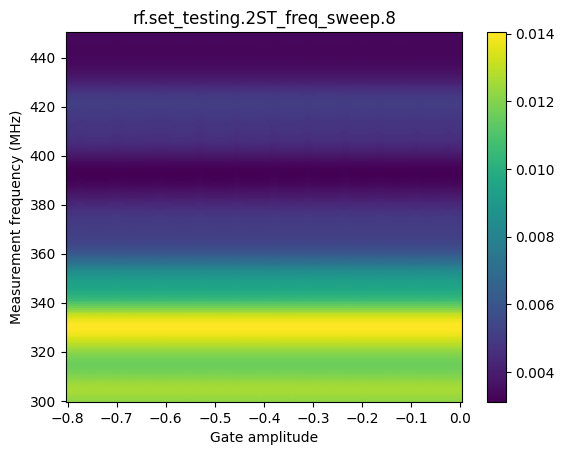

In [29]:
# better version of above

start_freq = 300.0e6
stop_freq = 450.0e6
num_points = 201

# frequencies to sweep over
freq_sweep = LinearSweepParameter(
    uid ="res_freq_set",
    start = start_freq,
    stop = stop_freq,
    count = num_points,
    axis_name="Frequency [Hz]"
)

# define the gate DC pulses
dr_pulse_len = 120e-6
dr_pulse = pulse_library.const(uid = "dr_pulse", amplitude = 1.0, length = dr_pulse_len, can_compress=True)
dr_amp_sweep = LinearSweepParameter("dr_amp", start=-0.8, stop = 0.0, count=101)

exp_set_freq_sweep = qubit_parameters.copy()
exp_set_freq_sweep.update({
    "exp_name": "sweep",
    "wait_after_int": 10e-6,
    "integration_time": 100e-6,
    "ro_osc_gain": 0.5,
    
    "num_averages": 8,
    "dr_pout_range": 5,
    "ro_pout_range": -20,
    "ro_pin_range": 0,

    "freq_sweep": freq_sweep,  # frequencies to sweep over
    "dr_pulse": dr_pulse,  # drive pulse
    "dr_amp_sweep": dr_amp_sweep,  # linear DC sweep

    "ro_lo": 1e9,
})

monty.newrun("2ST freq sweep", exp_set_freq_sweep)
results = freqset2(session, exp_set_freq_sweep)
data = results.acquired_results["results"].data
monty.save({"data": data})


plt.pcolormesh(dr_amp_sweep.values, freq_sweep.values/1e6, np.abs(data), shading="nearest")
plt.colorbar()
plt.xlabel("Gate amplitude")
plt.ylabel("Measurement frequency (MHz)")
plt.title(monty.identifier + "." + monty.runname)
monty.savefig(plt, "2d")

Note this only takes into account of the abs of the data and ignores the rest


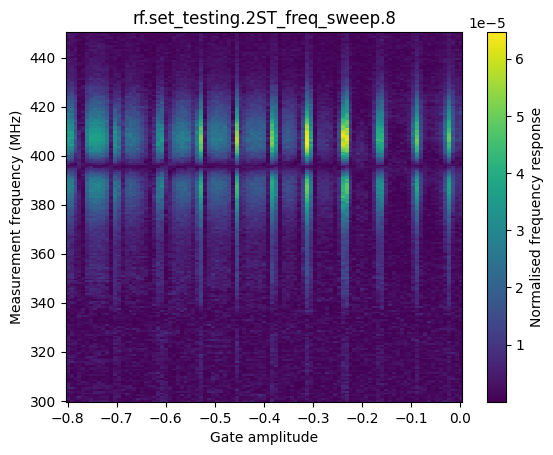

In [30]:
# normalise the frequency to their average value
d = np.abs(data.copy())
d -= np.repeat((np.sum(d, axis=1)/d.shape[1])[:, np.newaxis], d.shape[1], axis=1)
plt.pcolormesh(dr_amp_sweep.values, freq_sweep.values/1e6, np.abs(d), shading="nearest")
cb = plt.colorbar()
cb.ax.set_ylabel("Normalised frequency response")
plt.xlabel("Gate amplitude")
plt.ylabel("Measurement frequency (MHz)")
plt.title(monty.identifier + "." + monty.runname)
monty.savefig(plt, "normalised response")
print("Note this only takes into account of the abs of the data and ignores the rest")

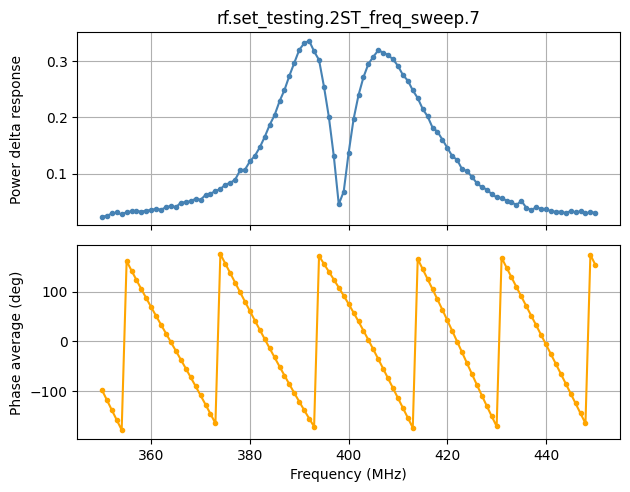

In [191]:
d = data.copy()

# recombine
h = np.zeros(len(freq_sweep.values))

pwr, phs = topower(d)
rng = np.max(pwr, axis=1)-np.min(pwr, axis=1)
phs_avg = np.average(phs, axis=1)
f = freq_sweep.values/1e6

fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
ax0.plot(f, rng, '.-', color = 'steelblue', label = 'power')
#ax0.legend(loc='upper left')
ax0.set_ylabel("Power delta response")
ax1.plot(f, phs_avg, '.-', color = 'orange', label = 'phase')
#ax1.legend(loc='upper left')
ax1.set_xlabel("Frequency (MHz)")
fig.align_ylabels([ax0, ax1])
ax0.grid()
ax1.grid()
ax1.set_ylabel('Phase average (deg)')
plt.tight_layout()
ax0.set_title(monty.identifier + "." + monty.runname)
monty.savefig(plt, "delta power response")

In [181]:
rng.shape

(31,)

In [ ]:
# plot the frequency derivative
d = data.copy()
plt.pcolormesh(dr_amp_sweep.values, freq_sweep.values[1:], np.abs(np.diff(d, axis=0)), shading="nearest")
plt.colorbar()

## Power sweep

In [31]:
# measure the SET drives over different powers

# define pulses

pwrs = [-30, -25, -20, -15, -10, -5]

dr_pulse_len = 120e-6
dr_pulse = pulse_library.const(uid = "dr_pulse", amplitude = 1.0, length = dr_pulse_len, can_compress=True)
dr_amp_sweep = LinearSweepParameter("dr_amp", start=-0.8, stop = 0.0, count=401)

data = {}

for pwr in tqdm(pwrs):
    exp_pwr_sweep = qubit_parameters.copy()
    exp_pwr_sweep.update({
        "exp_name": "sweep",
        "wait_after_int": 10e-6,
        "integration_time": 100e-6,
        "ro_osc_gain": 0.5,
    
        "set_freq": 406.6e6,
        "num_averages": 8,
        "dr_pout_range": 5,
        "ro_pout_range": pwr,
        "ro_pin_range": pwr,
    
        "dr_pulse": dr_pulse,  # drive pulse
        "dr_amp_sweep": dr_amp_sweep,  # linear DC sweep
    })
    
    monty.newrun("pwr set sweep", exp_pwr_sweep)
    results = spectroscopy(session, exp_pwr_sweep)
    
    data[str(pwr)] = results.acquired_results["results"].data
monty.save({"data": data})

#plot_sweeper(dr_amp_sweep, data, xlabel="Gate amplitude", monty=monty)

  0%|          | 0/6 [00:00<?, ?it/s]

Started new run pwr_set_sweep.16
[2024.07.04 14:08:04.039] INFO    Resolved modulation type of oscillator 'osc_36' on signal 'acquire' to HARDWARE
[2024.07.04 14:08:04.040] INFO    Resolved modulation type of oscillator 'osc_34' on signal 'drive_set' to HARDWARE
[2024.07.04 14:08:04.041] INFO    Starting LabOne Q Compiler run...
[2024.07.04 14:08:04.177] INFO    Schedule completed. [0.132 s]
[2024.07.04 14:08:16.152] INFO    Code generation completed for all AWGs. [11.975 s]
[2024.07.04 14:08:16.154] INFO    Completed compilation step 1 of 1. [12.109 s]
[2024.07.04 14:08:16.158] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.04 14:08:16.159] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.04 14:08:16.160] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.04 14:08:16.161] INFO      device_shfqc        0         12            0           0         0  
[2024.07.04 14:0

Text(0.5, 1.0, 'rf.set_testing.pwr_set_sweep.21')

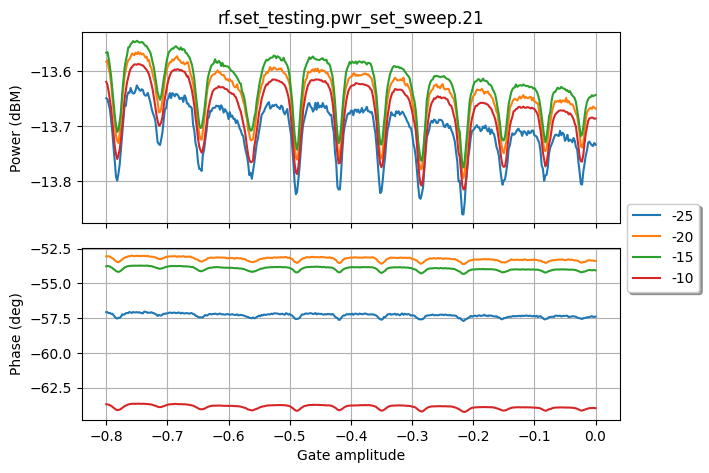

In [37]:
X = dr_amp_sweep.values

fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)

for pwr in pwrs[1:5]:

    power, phase = topower(data[str(pwr)])
    power -= pwr
    ax0.plot(X, power, '-', label = 'power')
    ax1.plot(X, phase, '-', label = str(pwr))


#ax0.legend(loc='upper left')
ax0.set_ylabel("Power (dBM)")
#ax1.legend(loc='upper left')
ax1.set_xlabel("Gate amplitude")
fig.align_ylabels([ax0, ax1])
ax0.grid()
ax1.grid()
ax1.set_ylabel("Phase (deg)")
plt.tight_layout()

box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax1.legend(loc='center left', bbox_to_anchor=(1.0, 1.0), fancybox=True, shadow=True, ncol=1)
               
ax0.set_title(monty.identifier + "." + monty.runname)
#monty.savefig(plt, "sweep")

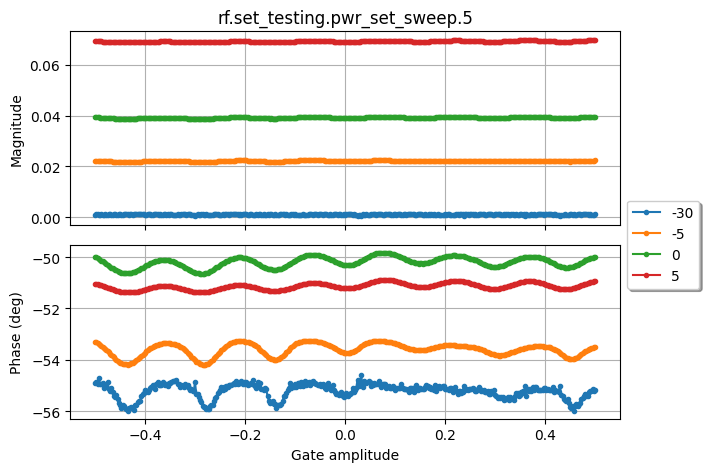

In [66]:
X = dr_amp_sweep.values

fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)

for pwr in pwrs:

    d = data[str(pwr)]
    power = np.abs(d)
    phase = np.unwrap(np.angle(d, deg = True))
    
    ax0.plot(X, power, '.-', label = 'power')
    ax1.plot(X, phase, '.-', label = str(pwr))


#ax0.legend(loc='upper left')
ax0.set_ylabel("Magnitude")
#ax1.legend(loc='upper left')
ax1.set_xlabel("Gate amplitude")
fig.align_ylabels([ax0, ax1])
ax0.grid()
ax1.grid()
ax1.set_ylabel("Phase (deg)")
plt.tight_layout()

box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax1.legend(loc='center left', bbox_to_anchor=(1.0, 1.0),
          fancybox=True, shadow=True, ncol=1)
               
ax0.set_title(monty.identifier + "." + monty.runname)
monty.savefig(plt, "sweep")

## Other sweeps (unfinished)

In [ ]:
# New pulse definition to compensate for the exponential decay of the AC-coupled gates. 
# Here, the gate pulses, and then rises linearly at a rate based on initial pulse amplitude and time.

In [14]:
g1_len = 100e-6
g2_len = 20e-6 # this pulse length and g1_len determines how many steps of sweeping g2 pulse, i.e. g1_len/g2_len

g1_pulse = pulse_library.const(uid = "g1_pulse", amplitude = 0.3, length = g1_len, can_compress=True)
g2_pulse = pulse_library.const(uid = "g2_pulse", amplitude = 0.3, length = g2_len, can_compress=True)
amp_sweep_g1 = LinearSweepParameter("amp_g1", start=-0.0, stop = 1.0, count=401)

# Experiment
exp = Experiment(uid="set sweep", 
    signals = [
            ExperimentSignal("drive_set", map_to=lsg["set"]["drive_line"]), # add additional drive lines for P1, P2, etc
            ExperimentSignal("measure", map_to=lsg["set"]["measure_line"]),
            ExperimentSignal("acquire", map_to=lsg["set"]["acquire_line"]),  
    ]  
)

with exp.acquire_loop_rt(uid="shots",
                         count=2**3,
                         acquisition_type = AcquisitionType.SPECTROSCOPY,
                         averaging_mode = AveragingMode.CYCLIC):
    with exp.sweep(uid='sweep set', parameter=amp_sweep_g1):
        with exp.section(uid="drivers", alignment = SectionAlignment.RIGHT):
            with exp.section(uid="control"):
                exp.play(signal="drive_set", pulse=g1_pulse, amplitude = amp_sweep_g1, phase = 180)
                # note that the phase does not affect the output amplitude 
            with exp.section(uid="readout"):
                # necessary to add measurement/acquire pulse?
                
                # exp.acquire(signal="acquire",
                #             handle="results",
                #             length=50e-6)
                
                exp.measure(acquire_signal="acquire",
                            handle = "results",
                            integration_length=50e-6,
                            reset_delay=1000e-6)
                
cal = Calibration()

cal["drive_set"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=5)

cal["acquire"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    oscillator=Oscillator(frequency=395.0e6),
    # port_delay = 100e-6,
    range=0)

exp.set_calibration(cal)

           
compiler_settings = None
compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
results = session.run(compiled_exp)    
Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
show_pulse_sheet(f'''Pulse_Sheets/csd''', compiled_exp) 


data = results.acquired_results["results"].data

[2024.06.19 10:53:44.602] INFO    Resolved modulation type of oscillator 'osc_9' on signal 'acquire' to HARDWARE
[2024.06.19 10:53:44.603] INFO    Resolved modulation type of oscillator 'osc_7' on signal 'drive_set' to HARDWARE
[2024.06.19 10:53:44.604] INFO    Starting LabOne Q Compiler run...
[2024.06.19 10:53:44.672] INFO    Schedule completed. [0.065 s]
[2024.06.19 10:53:54.398] INFO    Code generation completed for all AWGs. [9.724 s]
[2024.06.19 10:53:54.399] INFO    Completed compilation step 1 of 1. [9.792 s]
[2024.06.19 10:53:54.404] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.19 10:53:54.405] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.19 10:53:54.406] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.19 10:53:54.407] INFO      device_shfqc        0         13            0           0         0  
[2024.06.19 10:53:54.408] INFO      device_shfqc_sg  

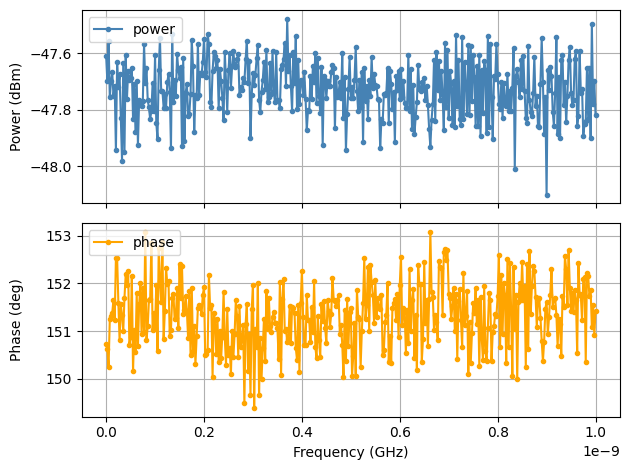

In [15]:
plot_sweeper(amp_sweep_g1, data)

## P1 sweep

In [332]:
g1_len = 100e-6
g2_len = 20e-6 # this pulse length and g1_len determines how many steps of sweeping g2 pulse, i.e. g1_len/g2_len

g1_pulse = pulse_library.const(uid = "g1_pulse", amplitude = 0.1, length = g1_len, can_compress=True)
g2_pulse = pulse_library.const(uid = "g2_pulse", amplitude = 0.1, length = g2_len, can_compress=True)
amp_sweep_g1 = LinearSweepParameter("amp_g1", start=-0.0, stop = 0.1, count=11)

# Experiment
exp = Experiment(uid="set sweep", 
    signals = [
        ExperimentSignal("drive_set", map_to=lsg["set"]["drive_line"]), 
        ExperimentSignal("drive_bt", map_to=lsg["bt"]["drive_line"]),
        ExperimentSignal("drive_p1", map_to=lsg["p1"]["drive_line"]),
        ExperimentSignal("measure", map_to=lsg["set"]["measure_line"]),
        ExperimentSignal("acquire", map_to=lsg["set"]["acquire_line"]),  
    ]  
)

with exp.acquire_loop_rt(uid="shots",
                         count=2**3,
                         acquisition_type = AcquisitionType.SPECTROSCOPY,
                         averaging_mode = AveragingMode.CYCLIC):
    with exp.sweep(uid='sweep p1', parameter=amp_sweep_g1):
        with exp.section(uid="drivers", alignment = SectionAlignment.RIGHT):
            with exp.section(uid="control"):
                exp.play(signal="drive_set", pulse=g1_pulse, amplitude = amp_sweep_g1, phase = 180)
                # note that the phase does not affect the output amplitude 
                exp.play(signal="drive_p1", pulse=g2_pulse, amplitude = amp_sweep_g1, phase = 180)
            with exp.section(uid="readout"):
                # necessary to add measurement/acquire pulse?
                
                # exp.acquire(signal="acquire",
                #             handle="results",
                #             length=50e-6)
                
                exp.measure(acquire_signal="acquire",
                            handle = "results",
                            integration_length=50e-6,
                            reset_delay=1000e-6)
                
                
                
    # Where do we add feedback? There are no "loops" for us to add it in currently...
                
cal = Calibration()

cal["drive_set"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=5)

cal["drive_bt"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=5)

cal["drive_p1"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=5)

cal["acquire"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    oscillator=Oscillator(frequency=395.0e6),
    # port_delay = 100e-6,
    range=0)

exp.set_calibration(cal)

           
compiler_settings = None
compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
results = session.run(compiled_exp)    
Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
show_pulse_sheet(f'''Pulse_Sheets/csd''', compiled_exp) 


data = results.acquired_results["results"].data

[2024.07.12 13:31:34.207] INFO    Resolved modulation type of oscillator 'osc_707' on signal 'acquire' to HARDWARE
[2024.07.12 13:31:34.208] INFO    Resolved modulation type of oscillator 'osc_703' on signal 'drive_bt' to HARDWARE
[2024.07.12 13:31:34.209] INFO    Resolved modulation type of oscillator 'osc_705' on signal 'drive_p1' to HARDWARE
[2024.07.12 13:31:34.211] INFO    Resolved modulation type of oscillator 'osc_701' on signal 'drive_set' to HARDWARE
[2024.07.12 13:31:34.212] INFO    Starting LabOne Q Compiler run...
[2024.07.12 13:31:34.220] INFO    Schedule completed. [0.004 s]
[2024.07.12 13:31:34.559] INFO    Code generation completed for all AWGs. [0.337 s]
[2024.07.12 13:31:34.559] INFO    Completed compilation step 1 of 1. [0.344 s]
[2024.07.12 13:31:34.565] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.12 13:31:34.567] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.12 13:31:34.568] INF

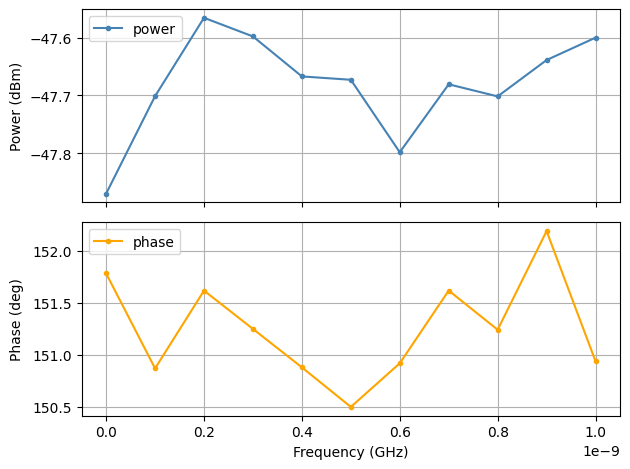

In [17]:
plot_sweeper(amp_sweep_g1, data)


# Quick Noise Spectroscopy

Here, we continuously measure the SET for a period of time, then FFT the results to see the noise on the signal

In [70]:
# create the experiment

# THIS IS NOT WORKING THE WAY I WANTED, IT TAKES WAY TOO LONG. INTENDED 15s SWEEP IS TAKING 1 HOUR. BEWARE AND FIX

def noise_spectroscopy(session, exp_params):
    exp = Experiment(uid=exp_params["exp_name"],
                     signals = [
                         ExperimentSignal(("drive_set"), map_to=lsg["set"]["drive_line"]),
                         ExperimentSignal(("measure"), map_to=lsg["set"]["measure_line"]),
                         ExperimentSignal(("acquire"), map_to=lsg["set"]["acquire_line"]),
                     ]
                    )
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"] + "_shots",
        count=2**exp_params["num_averages"],
        acquisition_type = AcquisitionType.SPECTROSCOPY,
        averaging_mode = AveragingMode.SEQUENTIAL,
    ):
        with exp.sweep(uid='sweep amp set', parameter=exp_params["dr_amp_sweep"]): # Is this a shit way of doing it? Maybe, but hopefully it works anyway
            with exp.section(uid="set_sweep", alignment = SectionAlignment.RIGHT):
                # with exp.section(uid = "g1_1"):
                #     exp.play(signal = "drive_set",
                #              pulse = exp_params["dr_pulse"],
                #              amplitude = exp_params["dr_amp_sweep"],
                #              phase = 180)  # note that the phase does not affect the output amplitude 

                with exp.section(uid="readout"):
                    exp.measure(
                        acquire_signal ="acquire",
                        handle = "results",
                        integration_length=exp_params["integration_time"],
                        reset_delay=exp_params["wait_after_int"],
                    )
                    

    cal = Calibration()
  
    cal["drive_set"] = SignalCalibration(
         local_oscillator=Oscillator(frequency=0),
         oscillator=Oscillator(frequency=0),  # exp_params["qb_freq"]),
         port_mode=PortMode.LF,
         range=exp_params["dr_pout_range"])
    
    cal["acquire"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),  # exp_params["ro_lo"]),
        port_mode=PortMode.LF,
        oscillator=Oscillator(frequency=exp_params["set_freq"]),
        # port_delay = 100e-6,
        range=exp_params["ro_pin_range"])

    cal["measure"] = SignalCalibration(
        #local_oscillator = Oscillator(frequency = exp_params["ro_lo"]),
        #oscillator=Oscillator(frequency=exp_params["qb_freq"]),
        port_mode=PortMode.LF,
        range = exp_params["ro_pout_range"]
    )

    exp.set_calibration(cal)

    results = compile_run(session, exp_params, exp)
    return results

136364
Started new run rf_ST_sweep.18
[2024.07.05 16:20:54.717] INFO    Resolved modulation type of oscillator 'osc_152' on signal 'acquire' to HARDWARE
[2024.07.05 16:20:54.718] INFO    Resolved modulation type of oscillator 'osc_150' on signal 'drive_set' to HARDWARE
[2024.07.05 16:20:54.720] INFO    Starting LabOne Q Compiler run...
[2024.07.05 16:22:45.619] INFO    Schedule completed. [110.895 s]
[2024.07.05 16:24:24.827] INFO    Code generation completed for all AWGs. [99.206 s]
[2024.07.05 16:24:24.828] INFO    Completed compilation step 1 of 1. [210.104 s]
[2024.07.05 16:24:24.839] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.05 16:24:24.840] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.05 16:24:24.841] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.05 16:24:24.842] INFO      device_shfqc        0         11            0           0         0  
[2024.

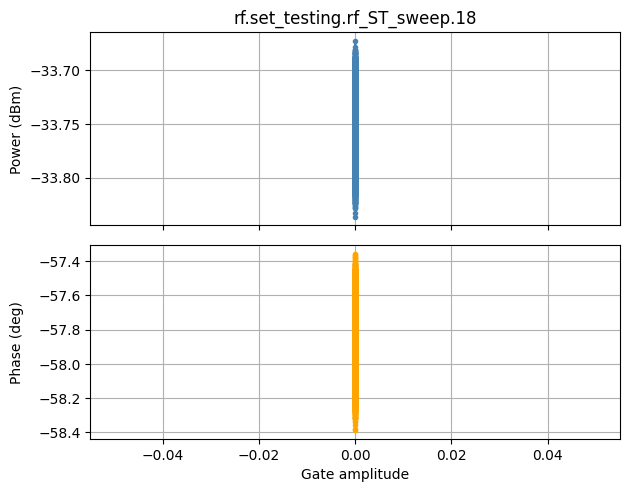

In [124]:
# define pulses

tShot = 110e-6
measurement_time_mins = 0.25
counts = int(np.round(measurement_time_mins * 60 / tShot))
print (counts)

dr_pulse_len = 120e-6
dr_pulse = pulse_library.const(uid = "dr_pulse", amplitude = 1.0, length = dr_pulse_len, can_compress=True)
dr_amp_sweep = LinearSweepParameter("dr_amp", start=0.0, stop = 0.0, count=counts)

exp_set_sweep = qubit_parameters.copy()
exp_set_sweep.update({
    "exp_name": "sweep",
    "wait_after_int": 10e-6,
    "integration_time": 100e-6,
    "ro_osc_gain": 0.5,

    "set_freq": 406.6e6,
    "num_averages": 2,
    "dr_pout_range": 5,
    "ro_pout_range": -20,
    "ro_pin_range": -10,

    "dr_pulse": dr_pulse,  # drive pulse
    "dr_amp_sweep": dr_amp_sweep,  # linear DC sweep
})

monty.newrun("rf ST sweep", exp_set_sweep)
results = noise_spectroscopy(session, exp_set_sweep)

data = results.acquired_results["results"].data
monty.save({"data": data})
plot_sweeper(dr_amp_sweep, data, xlabel="Gate amplitude", monty=monty)

In [59]:
data = results.acquired_results["results"].data
#monty.save({"data": data})
#plot_sweeper(dr_amp_sweep, data, xlabel="Gate amplitude", monty=monty)
print(len(data))

401


15.00004


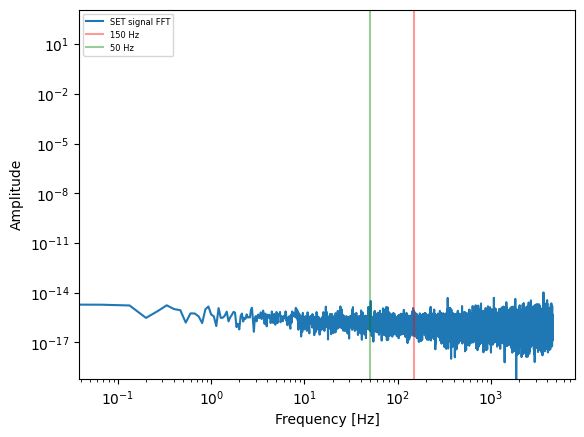

In [121]:
from scipy.fft import fft, fftfreq

pts = len(data)
pts_time = 110e-6
time = pts * pts_time
print(time)

yf = fft(data)
xf = fftfreq(pts, pts_time)[:pts//2]

def plot_SET_noise(xf, yf, xlabel="Frequency (Hz)", ylabel="Amplitude", monty=None):
    """Plot results from SET noise"""
    fig = plt.figure()
    plt.loglog(xf, 2.0/pts * np.abs(yf[0:pts//2]), alpha = 1, label='SET signal FFT')
    plt.ylabel('Amplitude')
    plt.xlabel('Frequency [Hz]')
    # plt.xlim([5e5,2e6])
    plt.axvline(x=150, color='r', alpha=0.4, label='150 Hz')
    plt.axvline(x=50, color='g', alpha=0.4, label='50 Hz')
    plt.legend(loc=2, prop={'size': 6})
    if monty is not None:
        ax0.set_title(monty.identifier + "." + monty.runname)
        monty.savefig(plt, "sweep")
    else:
        plt.show()

plot_SET_noise(xf, yf, monty=monty)

272727


# Pulse and Ramp function

Here we want to define pulses for P1 and P2 that have a ramp function to compensate for the capacitor decay of these AC-coupled lines

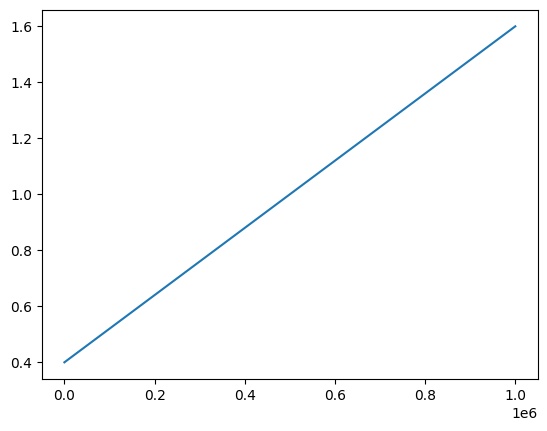

In [10]:
# pulse_library.PulseFunctional.pulse_parameters = dict(sampling_rate = 1e8)

@pulse_library.register_pulse_functional
def pulse_and_ramp(x, sampling_rate = 1e8, **_): 
    '''
    Needs calibration of the ramp rate. Current ramp rate is a carryover from QM, which requires user voltage inputs and has a different clock rate to SHFQC.
    This is easy to do. Simply pulse on P1 (or P2) for a set period of time and continuously measure response from SET. We want to see a square pulse response here,
    and if it's decaying or increasing then we adjust the ramp rate accordingly.
    '''
    res = np.ones(len(x))
    # res = np.linspace(0,1,len(x))
    # ramp_rate = 7.8e-7*x + 0.4e-8 
    ramp_rate = 0.6*x
    res += ramp_rate
    return res


#x0 = np.linspace(0, 1, 501)
#pulse_and_ramp().evaluate(x=x0)
time, wfm = pulse_and_ramp(amplitude = 1, length=1000e-6).generate_sampled_pulse(sampling_rate = 1e9)
plt.plot(time * 1e9, wfm.real)

#plt.plot(x0,pulse_and_ramp().evaluate(x=x0))

In [176]:
# Trying to define a sampled pulse now...

sample_length = 1000
amplitude = 1

amp_list = np.linspace(amplitude, amplitude + 7.8e-7*amplitude + 0.4e-8, sample_length)

sampled_ramp_pulse = pulse_library.PulseSampled(samples = amp_list, uid = 'ramp_pulse')

In [328]:
# PULSE SIMULATION, VERSION 1
# THIS USES RF SIGNALS, LIMITED TO 25us INTEGRATION TIME, WE WANT LONGER

g1_len = 20e-6
g2_len = 20e-6 # this pulse length and g1_len determines how many steps of sweeping g2 pulse, i.e. g1_len/g2_len

g1_pulse = pulse_and_ramp(uid = "g1_pulse", amplitude = 0.3, length = g1_len, can_compress=False)
g2_pulse = pulse_and_ramp(uid = "g2_pulse", amplitude = 0.3, length = g2_len, can_compress=False)
amp_sweep_g1 = LinearSweepParameter("amp_g1", start=-1.0, stop = 1.0, count=4)

# Experiment
exp = Experiment(uid="set sweep", 
    signals = [
        # ExperimentSignal("drive_set", map_to=lsg["set"]["drive_line"]), 
        # ExperimentSignal("drive_bt", map_to=lsg["bt"]["drive_line"]),
        ExperimentSignal("drive_p1", map_to=lsg["p1"]["drive_line"]),
        # ExperimentSignal("measure", map_to=lsg["set"]["measure_line"]),
        # ExperimentSignal("acquire", map_to=lsg["set"]["acquire_line"]),  
    ]  
)

with exp.acquire_loop_rt(uid="shots",
                         count=2**0, # no averaging
                         acquisition_type = AcquisitionType.SPECTROSCOPY,
                         averaging_mode = AveragingMode.CYCLIC):
    with exp.sweep(uid='sweep p1', parameter=amp_sweep_g1):
        with exp.section(uid="drivers", alignment = SectionAlignment.RIGHT):
            with exp.section(uid="control"):
                # note that the phase does not affect the output amplitude 
                exp.play(signal="drive_p1", pulse=g1_pulse, amplitude = amp_sweep_g1, phase = 180)
                #exp.delay(signal="drive_p1", time=1e-6)
                #exp.play(signal="drive_p1", pulse=sampled_ramp_pulse, amplitude = amp_sweep_g1, phase = 180)
                

cal = Calibration()

cal["drive_p1"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=5)

exp.set_calibration(cal)

           
compiler_settings = None
compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
results = session.run(compiled_exp)    
Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
show_pulse_sheet(f'''Pulse_Sheets/csd''', compiled_exp) 

#data = results.acquired_results["results"].data

[2024.07.12 12:26:18.660] INFO    Resolved modulation type of oscillator 'osc_695' on signal 'drive_p1' to HARDWARE
[2024.07.12 12:26:18.662] INFO    Starting LabOne Q Compiler run...
[2024.07.12 12:26:18.667] INFO    Schedule completed. [0.002 s]
[2024.07.12 12:26:18.686] INFO    Code generation completed for all AWGs. [0.018 s]
[2024.07.12 12:26:18.687] INFO    Completed compilation step 1 of 1. [0.022 s]
[2024.07.12 12:26:18.693] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.12 12:26:18.694] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.12 12:26:18.696] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.12 12:26:18.697] INFO      device_shfqc_sg     1         13            4           2    160000  
[2024.07.12 12:26:18.698] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.12 12:26:18.699] INFO      TOTAL                  

C:\Users\LD2007\Documents\Si_CMOS_james\quench\june\Pulse_Sheets\csd_2024-07-12-12-26-18.html

In [329]:
# PULSE DECAY OBSERVATION
# Measures SET, pulses on P1, measures SET again

pulse_amp = 0.2 # corresponds to an ~85 mV pulse
pulse_time_sweep = LinearSweepParameter("pulse_time", start=1e-6, stop = 2e-3, count=50)
p1_pulse = pulse_library.const(uid = "p1_pulse", amplitude = pulse_amp, length = pulse_time_sweep, can_compress=True)

p1_decay_sweep = qubit_parameters.copy()
p1_decay_sweep.update({
    "exp_name": "sweep",
    "wait_after_int": 10e-6, # 10e-6
    "integration_time": 100e-6, # 100e-6
    "ro_osc_gain": 0.5,

    "set_freq": 406.6e6,
    "num_averages": 1,
    "dr_pout_range": 0,
    "ro_pout_range": -20,
    "ro_pin_range": -10,

    "dr_pulse": dr_pulse,  # drive pulse
    "dr_amp_sweep": dr_amp_sweep,  # linear DC sweep
})

# create the experiment
def p1_decay(session, exp_params):
    exp = Experiment(uid=exp_params["exp_name"],
                     signals = [
                         ExperimentSignal("drive_p1", map_to=lsg["p1"]["drive_line"]),
                         ExperimentSignal(("measure"), map_to=lsg["set"]["measure_line"]),
                         ExperimentSignal(("acquire"), map_to=lsg["set"]["acquire_line"]),
                     ]
                    )
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"] + "_shots",
        count=2**0,
        acquisition_type = AcquisitionType.SPECTROSCOPY,
        averaging_mode = AveragingMode.SEQUENTIAL,
    ):
        with exp.sweep(uid='P1 decay', parameter=pulse_time_sweep):
            with exp.section(uid="P1_time_sweep", alignment = SectionAlignment.RIGHT):
                with exp.section(uid = "g1_1"):
                    # exp.delay(signal="drive_p1", time=4e-6)  # delay the P1 pulse to allow the signal to settle. Recommend 4ms
                    exp.play(signal = "drive_p1",            # pulse P1 for fixed amplitude and varying time
                             pulse = p1_pulse,
                             amplitude = pulse_amp,
                             length = pulse_time_sweep,
                             phase = 180)

                with exp.section(uid="readout"):             # readout the decay signal immediately after pulse
                    exp.measure(
                        acquire_signal ="acquire",
                        handle = "results",
                        integration_length=25e-6,
                        reset_delay=10e-6,
                    )

    cal = Calibration()
  
    cal["drive_p1"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),
        oscillator=Oscillator(frequency=0),  # exp_params["qb_freq"]),
        port_mode=PortMode.LF,
        range=exp_params["dr_pout_range"])
    
    cal["acquire"] = SignalCalibration(
        local_oscillator=Oscillator(frequency=0),  # exp_params["ro_lo"]),
        port_mode=PortMode.LF,
        oscillator=Oscillator(frequency=exp_params["set_freq"]),
        port_delay = 10e-6,
        range=exp_params["ro_pin_range"])

    cal["measure"] = SignalCalibration(
        #local_oscillator = Oscillator(frequency = exp_params["ro_lo"]),
        #oscillator=Oscillator(frequency=exp_params["qb_freq"]),
        port_mode=PortMode.LF,
        range = exp_params["ro_pout_range"]
    )

    exp.set_calibration(cal)

    results = compile_run(session, exp_params, exp)
    return results

# monty.newrun("rf P1 decay sweep", exp_set_sweep)
# results = p1_decay(session, exp_set_sweep)

# data = results.acquired_results["results"].data
# monty.save({"data": data})
# plot_sweeper(pulse_time_sweep*1e9, data, xlabel="Gate time (s)", monty=monty)


compiler_settings = None
compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
results = session.run(compiled_exp)    
Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
show_pulse_sheet(f'''Pulse_Sheets/csd''', compiled_exp) 

[2024.07.12 12:30:04.086] INFO    Resolved modulation type of oscillator 'osc_695' on signal 'drive_p1' to HARDWARE
[2024.07.12 12:30:04.089] INFO    Starting LabOne Q Compiler run...
[2024.07.12 12:30:04.091] INFO    Schedule completed. [0.001 s]
[2024.07.12 12:30:04.105] INFO    Code generation completed for all AWGs. [0.013 s]
[2024.07.12 12:30:04.106] INFO    Completed compilation step 1 of 1. [0.015 s]
[2024.07.12 12:30:04.110] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.12 12:30:04.111] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.12 12:30:04.112] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.12 12:30:04.113] INFO      device_shfqc_sg     1         13            4           2    160000  
[2024.07.12 12:30:04.114] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.12 12:30:04.115] INFO      TOTAL                  

C:\Users\LD2007\Documents\Si_CMOS_james\quench\june\Pulse_Sheets\csd_2024-07-12-12-30-04.html

[2024.07.15 11:24:57.507] INFO    Resolved modulation type of oscillator 'osc_1111' on signal 'acquire' to HARDWARE
[2024.07.15 11:24:57.508] INFO    Resolved modulation type of oscillator 'osc_1107' on signal 'drive_bt' to HARDWARE
[2024.07.15 11:24:57.509] INFO    Resolved modulation type of oscillator 'osc_1109' on signal 'drive_p1' to HARDWARE
[2024.07.15 11:24:57.510] INFO    Resolved modulation type of oscillator 'osc_1105' on signal 'drive_set' to HARDWARE
[2024.07.15 11:24:57.511] INFO    Starting LabOne Q Compiler run...
[2024.07.15 11:24:57.544] INFO    Schedule completed. [0.031 s]
[2024.07.15 11:25:17.755] INFO    Code generation completed for all AWGs. [20.210 s]
[2024.07.15 11:25:17.756] INFO    Completed compilation step 1 of 1. [20.243 s]
[2024.07.15 11:25:17.763] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.15 11:25:17.764] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.15 11:25:17.76

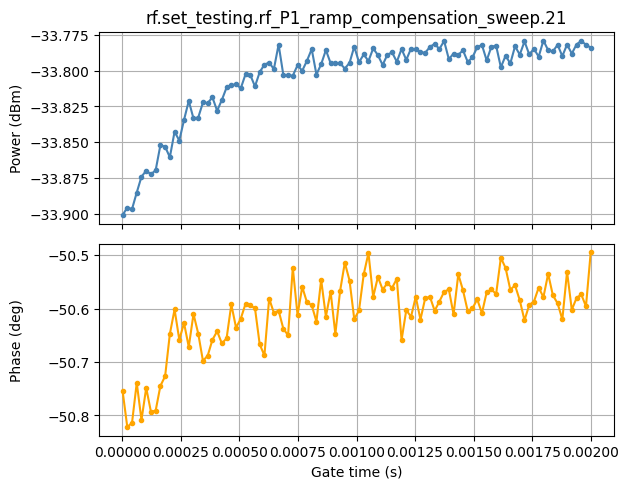

In [387]:
# VERSION 2

pulse_amp = 1 # corresponds to an ~85 mV pulse
pulse_time_sweep = LinearSweepParameter("pulse_time", start=1e-6, stop = 2e-3, count=100)
p1_pulse = pulse_library.const(uid = "p1_pulse", amplitude = pulse_amp, length = pulse_time_sweep, can_compress=True)

# g1_len = 100e-6
# g2_len = 20e-6 # this pulse length and g1_len determines how many steps of sweeping g2 pulse, i.e. g1_len/g2_len

# g1_pulse = pulse_library.const(uid = "g1_pulse", amplitude = 0.1, length = g1_len, can_compress=True)
# g2_pulse = pulse_library.const(uid = "g2_pulse", amplitude = 0.1, length = g2_len, can_compress=True)
# amp_sweep_g1 = LinearSweepParameter("amp_g1", start=-0.0, stop = 0.1, count=11)

# Experiment
exp = Experiment(uid="set sweep", 
    signals = [
        ExperimentSignal("drive_set", map_to=lsg["set"]["drive_line"]), 
        ExperimentSignal("drive_bt", map_to=lsg["bt"]["drive_line"]),
        ExperimentSignal("drive_p1", map_to=lsg["p1"]["drive_line"]),
        ExperimentSignal("measure", map_to=lsg["set"]["measure_line"]),
        ExperimentSignal("acquire", map_to=lsg["set"]["acquire_line"]),  
    ]  
)

with exp.acquire_loop_rt(uid="shots",
                         count=2**8, # CHANGE THIS
                         acquisition_type = AcquisitionType.SPECTROSCOPY,
                         averaging_mode = AveragingMode.CYCLIC):
    with exp.sweep(uid='sweep p1', parameter=pulse_time_sweep):
        with exp.section(uid="drivers", alignment = SectionAlignment.RIGHT):
            with exp.section(uid="control"):
                exp.delay(signal="drive_p1", time=4e-3)  # delay the P1 pulse to allow the signal to settle. Recommend 4ms
                # exp.play(signal="drive_set", pulse=g1_pulse, amplitude = amp_sweep_g1, phase = 180)
                exp.play(signal="drive_p1", pulse=p1_pulse, amplitude = pulse_amp, length = pulse_time_sweep, phase = 180)
            with exp.section(uid="readout"):
                # necessary to add measurement/acquire pulse?
                
                # exp.acquire(signal="acquire",
                #             handle="results",
                #             length=50e-6)
                
                exp.measure(acquire_signal="acquire",
                            handle = "results",
                            integration_length=25e-6,
                            reset_delay=10e-6)
                
                
                
    # Where do we add feedback? There are no "loops" for us to add it in currently...
                
cal = Calibration()

cal["drive_set"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=5)

cal["drive_bt"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=5)

cal["drive_p1"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=0)

cal["acquire"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    oscillator=Oscillator(frequency=406.6e6),
    port_delay = 100e-6,
    range=0)

exp.set_calibration(cal)

           
# compiler_settings = None
# compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
# results = session.run(compiled_exp)    
# Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# show_pulse_sheet(f'''Pulse_Sheets/csd''', compiled_exp) 
# monty.newrun("rf P1 ramp compensation sweep", exp_set_sweep)
# #results = p1_decay(session, exp_set_sweep)

# data = results.acquired_results["results"].data
# monty.save({"data": data})
# plot_sweeper(pulse_time_sweep, data, xlabel="Gate time", monty=monty)

# monty.newrun("rf P1 decay sweep", exp_set_sweep)
# results = p1_decay(session, exp_set_sweep)

# data = results.acquired_results["results"].data
# monty.save({"data": data})
# plot_sweeper(pulse_time_sweep*1e9, data, xlabel="Gate time (s)", monty=monty)

compiler_settings = None
compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
results = session.run(compiled_exp)    
Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
show_pulse_sheet(f'''Pulse_Sheets/csd''', compiled_exp) 


data = results.acquired_results["results"].data
monty.save({"data": data})
plot_sweeper(pulse_time_sweep*1e9, data, xlabel="Gate time (s)", monty=monty)


[2024.07.25 14:07:11.254] INFO    Resolved modulation type of oscillator 'osc_135' on signal 'acquire' to HARDWARE
[2024.07.25 14:07:11.256] INFO    Resolved modulation type of oscillator 'osc_131' on signal 'drive_bt' to HARDWARE
[2024.07.25 14:07:11.256] INFO    Resolved modulation type of oscillator 'osc_133' on signal 'drive_p1' to HARDWARE
[2024.07.25 14:07:11.258] INFO    Resolved modulation type of oscillator 'osc_129' on signal 'drive_set' to HARDWARE
[2024.07.25 14:07:11.259] INFO    Starting LabOne Q Compiler run...
[2024.07.25 14:07:11.263] INFO    Schedule completed. [0.001 s]
[2024.07.25 14:07:11.287] INFO    Requested to compress pulse(s) p1_pulse which has(have) either no, or too short, constant sections. Skipping compression
[2024.07.25 14:07:11.291] INFO    Requested to compress pulse(s) p1_pulse which has(have) either no, or too short, constant sections. Skipping compression
[2024.07.25 14:07:11.297] INFO    Code generation completed for all AWGs. [0.033 s]
[2024.07.2

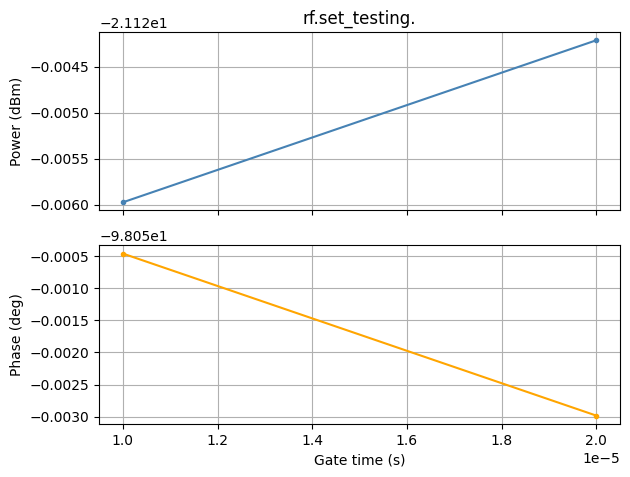

In [27]:
# PULSE RAMP COMPENSATION
# Measures SET, pulses on P1, measures SET again

# pulse_amp = 1.0
# pulse_time_sweep = LinearSweepParameter("pulse_time", start=1e-6, stop = 100e-6, count=100)
# p1_pulse = pulse_and_ramp(uid = "p1_pulse", amplitude = pulse_amp, length = pulse_time_sweep, can_compress=True)
                    # exp.play(signal = "drive_p1",            # pulse P1 for fixed amplitude and varying time
                    #          pulse = p1_pulse,
                    #          amplitude = pulse_amp,
                    #          length = pulse_time_sweep,
                    #          phase = 180)

pulse_amp = 0.5 # corresponds to an ~85 mV pulse
pulse_time_sweep = LinearSweepParameter("pulse_time", start=10e-6, stop = 20e-6, count=2)
# p1_pulse = pulse_library.const(uid = "p1_pulse", amplitude = pulse_amp, length = pulse_time_sweep, can_compress=True)
p1_pulse = pulse_and_ramp(uid = "p1_pulse", amplitude = pulse_amp, length = pulse_time_sweep, can_compress=True)

# Experiment
exp = Experiment(uid="set sweep", 
    signals = [
        ExperimentSignal("drive_set", map_to=lsg["set"]["drive_line"]), 
        ExperimentSignal("drive_bt", map_to=lsg["bt"]["drive_line"]),
        ExperimentSignal("drive_p1", map_to=lsg["p1"]["drive_line"]),
        ExperimentSignal("measure", map_to=lsg["set"]["measure_line"]),
        ExperimentSignal("acquire", map_to=lsg["set"]["acquire_line"]),  
    ]  
)

with exp.acquire_loop_rt(uid="shots",
                         count=2**0, # CHANGE THIS
                         acquisition_type = AcquisitionType.SPECTROSCOPY,
                         averaging_mode = AveragingMode.CYCLIC):
    with exp.sweep(uid='sweep p1', parameter=pulse_time_sweep):
        with exp.section(uid="drivers", alignment = SectionAlignment.RIGHT):
            with exp.section(uid="control"):
                exp.delay(signal="drive_p1", time=4e-3)  # delay the P1 pulse to allow the signal to settle. Recommend 4ms
                # exp.play(signal="drive_set", pulse=g1_pulse, amplitude = amp_sweep_g1, phase = 180)
                exp.play(signal="drive_p1", pulse=p1_pulse, amplitude = pulse_amp, length = pulse_time_sweep, phase = 180)
            with exp.section(uid="readout"):
                # necessary to add measurement/acquire pulse?
                
                # exp.acquire(signal="acquire",
                #             handle="results",
                #             length=50e-6)
                
                exp.measure(acquire_signal="acquire",
                            handle = "results",
                            integration_length=25e-6,
                            reset_delay=10e-6)
                
                
                
    # Where do we add feedback? There are no "loops" for us to add it in currently...
                
cal = Calibration()

cal["drive_set"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=5)

cal["drive_bt"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=5)

cal["drive_p1"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    range=0)

cal["acquire"] = SignalCalibration(
    local_oscillator=Oscillator(frequency=0),
    port_mode=PortMode.LF,
    oscillator=Oscillator(frequency=406.6e6),
    port_delay = 100e-6,
    range=0)

exp.set_calibration(cal)

compiler_settings = None
compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
results = session.run(compiled_exp)    
Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
show_pulse_sheet(f'''Pulse_Sheets/csd''', compiled_exp) 


data = results.acquired_results["results"].data
monty.save({"data": data})
plot_sweeper(pulse_time_sweep*1e9, data, xlabel="Gate time (s)", monty=monty)

# SET Feedback (toolkit)

Now instead if useing the LabOne code, we are using ToolKit, which gives us better control over the gates themselves and allows access to more higher level processes. It is a bit more verbose in terms of its operation, but more flexible too, and it's that flexibility we need. Also easier to change sampling rate too, which is something we desparately need.

In [451]:
from zhinst.toolkit import Session
import random
import numpy as np
from IPython.display import display, clear_output
import time

import matplotlib.pyplot as plt

dataserver_ip = "localhost"
dataserver_port = 8004
device_id = "DEV12158"

session = Session(dataserver_ip, dataserver_port)
device = session.connect_device(device_id)
fs = 2e9

device.system.preset.load(1) 
device.system.preset.load.wait_for_state_change(0)

In [452]:
def get_results(result_node, timeout):
    wave_data_captured = {}
    wave_data_captured[result_node] = False
    start_time = time.time()
    captured_data = {}
    while not all(wave_data_captured.values()):
        if start_time + timeout < time.time():
            raise TimeoutError('Timeout before all samples collected.')
        test = session.poll()
        for node, value in test.items():
            node = session.raw_path_to_node(node)
            for v in value:
                if node not in captured_data:
                    captured_data[node] = [v['vector']]
                else:
                    captured_data[node].append(v['vector'])
            if len(captured_data[node]) >= 1: # readout 1 point
                wave_data_captured[node] = True
                total_num_data = sum([len(element) for element in captured_data[node]])
    data = captured_data[result_node][0]
    return data